#### 数据的处理
前面的程序只能说是跑通，由于维度不匹配的问题，网络现在还无法正常训练，下面对输入输出数据进行处理，使其能够正常训练优化

如果按照我自己的想法，肯定是先对图像进行处理，处理结束后再基于新数据构建新的数据集，输入到网络进行训练，但是这么做有两个问题：

- 1.每次想添加新的处理方法的话就必须重新设计程序，这样程序和新生成的数据都会有很多，次数多了就会变得很乱。
- 2.对输入进行处理之后，必须也得对理想的标注信息进行同样的处理，这样才能保证训练正确，以裁剪处理为例，原始图像裁剪之后可以方便地获得新的图像，但是前面看到过，抓取框的标注信息都是以坐标形式保存的，当图像的四周被裁去之后，这个坐标肯定就是变了的，应用坐标变换的方式可能能够解决，但加上旋转，镜像等操作之后呢，无疑需要复杂的设计和运算才能保证最终的正确对应。
  
网络所标注的理想输出是由一张张的映射图来代表的，也就是说，最终这些损失的计算都不是根据各个参数啊，坐标这些来算的，而是直接针对两个图来进行，理想输出在这里面也是图，所以，我们只要把理想的原始输出图构建好了，数据增强处理之前它肯定是和原始的输入图是有对应关系的，输入与标注的对应关系也都在，所以，这个时候对它们应用相同的变换之后，结果肯定也是相互对应的。

#### 处理1.裁剪
##### 输入的裁剪
不是方形的图片在后面的处理中总有可能出各种幺蛾子，但直接resize成方形的话又不能保证长宽比，所以考虑通过裁剪的方式，把图片的中心部分裁出来（可以看到边上全是背景，所以这么做是没有问题的）。

这项工作的执行需要两个参数：

- 1.中心点坐标
- 2.要裁出来的图像大小

图像大小自己指定长宽即可，中心点的坐标的确定有两个选择：

- 1.直接选图像的中心
- 2.多个抓取框的中心

这里保持跟GGCNN的一样，选择多个抓取框的中心，这么做的好处是可以保证对象位于最终裁出来的图片的中心，下面开始实操，先单个图片从测试，然后再将功能集成到抓取框类和图片类里面去。

- 1.抓取框类里面需要新添加一个计算多抓取框中心点坐标的函数
- 2.各个图像类需要添加一个裁剪函数，能够根据提供的中心点坐标和图像大小对原始图片进行裁剪


In [ ]:
# 读取文件地址
#先把文件都读进来
import os
import glob

cornell_path = '../../../../grasping_dataset/Conell_grasping_dataset'
cpos_path = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
cpos_path.sort()

rgb_path = [filename.replace('cpos.txt','r.png') for filename in cpos_path]
depth_path = [filename.replace('cpos.txt','d.tiff') for filename in cpos_path]

In [ ]:
from image import Image
from grasp import Grasps

In [ ]:
rgb_img = Image.from_file(rgb_path[520])
grasps = Grasps.load_from_cornell_files(cpos_path[520])

In [ ]:
# 测试一下引用的类生成的实例
print(rgb_img.img.shape)
for gr in grasps.grs:
    print(gr.center)

In [ ]:
# 计算多抓取框的平均中心点，即对所有抓取框的点的x,y坐标求平均
import numpy as np
centers = []
for gr in grasps.grs:
    centers.append(gr.center)
center = np.mean(np.array(centers), axis = 0).astype(np.uint)
print(center)

In [ ]:
# 裁剪先不做，先指定一个宽度的矩形结合这个中心点可视化一下看效果
import cv2
import matplotlib.pyplot as plt
output_size = (200, 200)

top_left = (int(center[0]-output_size[0]//2), int(center[1]-output_size[1]//2))
bottom_right = (int(center[0]+output_size[0]//2), int(center[1]+output_size[1]//2))

corp_demo = cv2.rectangle(rgb_img.img, top_left, bottom_right, (0,0,1))

plt.figure(figsize=(10,10))
plt.imshow(rgb_img.img)
plt.show()

裁剪的话也很简单，图片就是numpy数组，直接按照坐标对它切片就行
这里图片裁切需要解释一下：
top_left[1]:bottom_right[1] 代表图片矩阵的第一个维度，行维度。top_left[1]代表起始行，bottom_right[1]代表结束行
top_left[0]:bottom_right[0] 代表图片矩阵的第二个维度，列维度。top_left[0]代表起始列，bottom_right[1]代表结束列


In [ ]:
# 图片裁减
croped_img = rgb_img.img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
print(croped_img.shape)
plt.figure(figsize = (10,10))
plt.imshow(croped_img)
plt.show()

In [ ]:
n = np.random.randint(0,10,size=(2,2,3))
print(n)

将计算多个抓取框的中心点坐标作为特征加到Grasps class中

In [ ]:
from grasp import str2num
from grasp import Grasp

class Grasps:
    '''定义一个多抓取框处理类，主要功能是从原始的标注文件中读出多个抓取框并将其构建成多个单一的抓取框Grasp类，同时能够对这些属于同一对象的多个抓取框对象进行一些数据的统一集成处理'''
    def __init__(self,grs = None):
        '''
        :功能     : 多抓取框类初始化函数，功能是将属于一个对象的多个单独的抓取框集成到一个类里面来。
        :参数 grs : list,包含一个对象中多个抓取框类的列表
        '''
        if grs:
            self.grs = grs
        else:
            self.grs = []
    
    @classmethod
    def load_from_cornell_files(cls,cornell_grasp_files):
        '''
        :功能     : 从一个graspf文件中读取载入多个抓取框并构建成为这个类（其实就是从之前的那个get_rectangles改的）
        :参数 grs : list,包含一个对象中多个抓取框类的列表
        '''
        grasp_rectangles = []
        with open(cornell_grasp_files,'r') as f:
            while True:
                grasp_rectangle = []
                point0 = f.readline().strip()
                if not point0:
                    break
                point1,point2,point3 = f.readline().strip(),f.readline().strip(),f.readline().strip()
                if point0[0] == 'N':#后面发现有些坐标点坐标是NaN，会报错，这里处理一下，暂时还不晓得gg-cnn里面怎么处理的
                    break
                grasp_rectangle = np.array([str2num(point0),
                               str2num(point1),
                               str2num(point2),
                               str2num(point3)])
                grasp_rectangles.append(Grasp(grasp_rectangle))#找出各个框后就直接用它构造Grasp对象了

            return cls(grasp_rectangles)#返回实例化的类
        
    def generate_img(self,pos = True,angle = True,width = True,shape = (480,640)):
        '''
        :功能       :将本对象的多个的抓取框信息融合并生成指定的映射图，以这种方式返回定义一个抓取的多个参数，包括中心点，角度，宽度
        :参数 pos   :bool,是否生成返回位置映射图
        :参数 angle :bool,是否生成返回角度映射图
        :参数 width :bool,是否生成返回夹爪宽度映射图
        :参数 shape :tuple
        :返回       :融合本对象的多个抓取框信息的映射图
        '''
        
        if pos:
            pos_out = np.zeros(shape)
        else:
            pos_out = None
        if angle:
            angle_out = np.zeros(shape)
        else:
            angle_out = None
        if width:
            width_out = np.zeros(shape)
        else:
            width_out = None
        
        for gr in self.grs:
            rr,cc = gr.compact_polygon_coords(shape)#shape的指定还是很重要的，可以考虑图像边界
            
            if pos:
                pos_out[cc,rr] = 1.0
            if angle:
                angle_out[cc,rr] = gr.angle
            if width:
                width_out[cc,rr] = gr.width

        return pos_out,angle_out,width_out
    
    @property
    def center(self):
        '''
        :功能       :计算本类中所包含的多个抓取框共同的中心
        :返回       :ndarray，中心坐标
        '''
        centers = []
        for gr in self.grs:
            centers.append(gr.center)
        center = np.mean(np.array(centers), axis=0).astype(np.uint)
        return center

In [ ]:
grasps = Grasps.load_from_cornell_files(cpos_path[520])
grasps.center

In [ ]:
#import cv2 #这块本来是用cv2.imread来做读取的，后面发现读不了tiff，所以就改用imageio了
from imageio import imread
import numpy as np

class Image:
    '''定义一个图像类，主要功能是将原始的图像输入转化为适合网络训练的格式并根据图像处理需求完成一些其他功能'''
    def __init__(self,img):
        '''
        :功能 :类初始化函数
        :参数 :ndarray,原始图像
        '''
        self.img = img
    
    @classmethod
    def from_file(cls, file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(imread(file_path))
    
    def img_format(self):
        '''
        :功能 :将原始图像转换为指定格式
        '''
        pass

    def normalize(self):
        '''
        :功能 :将图像像素值标准化至[0,1]范围
        '''
        self.img = self.img.astype('float32')/255.0
        self.img = self.img-self.img.mean()

    def crop(self, top_left, bottom_right):
        '''
        :功能              :按照给定参数对图像进行裁剪操作
        :参数 top_left     :ndarray,要裁剪区域的左上角点坐标
        :参数 bottom_right :ndarray,要裁剪区域的右下角点坐标
        '''
        self.img = self.img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

In [ ]:
class DepthImage(Image):
        '''深度图像类，读取，载入，正则等预处理都是一样的，后面可能会添加一些针对深度图的专属处理功能'''
        def __init__(self,img):
            super(DepthImage,self).__init__(img)  

In [ ]:
rgb_img = Image.from_file(rgb_path[520])
rgb_img.crop(top_left,bottom_right)
plt.imshow(rgb_img.img)
plt.show()

In [ ]:
depth_img = DepthImage.from_file(depth_path[520])
depth_img.crop(top_left,bottom_right)
depth_img.normalize()
plt.imshow(depth_img.img)
plt.show()

直接仿照ggcnn的放法，在cornell数据集类里面添加一个获取参数函数_get_crop_attrs()，这时候也得注意给cornell数据集添加一个output_size参数了。

In [ ]:
import torch

class Cornell(torch.utils.data.Dataset):
    #载入cornell数据集的类
    def __init__(self, file_dir, include_depth=True, include_rgb=True, start=0.0, end=1.0, output_size = 300):
        '''
        :功能               : 数据集封装类的初始化函数，功能包括数据集读取，数据集划分，其他参数初始化等
        :参数 file_dir      : str,按照官方文档的示例和之前的经验，这里需要读入数据集，所以需要指定数据的存放路径
        :参数 include_depth : bool,是否包含depth图像输入
        :参数 include_rgb   : bool,是否包含rgb图像输入
        :参数 output_size   : 各图片的输出大小，裁剪得到
        :参数 start,end     : float,为了方便数据集的拆分，这里定义添加两个边界参数start,end
        :返回 None
        ''' 
        super(Cornell,self).__init__()

        # 一些参数传递
        self.include_depth = include_depth
        self.include_rgb = include_rgb
        self.output_size = output_size
        #去指定路径载入数据集数据
        cpos_path = glob.glob(os.path.join(file_dir,'*','pcd*cpos.txt'))
        cpos_path.sort()

        l = len(cpos_path)
        if l == 0:
            raise FileNotFoundError('没有查找到数据集，请检查路径{}'.format(file_dir))
        
        rgb_path = [filename.replace('cpos.txt','r.png') for filename in cpos_path]
        depth_path = [filename.replace('cpos.txt','d.tiff') for filename in cpos_path]

        #按照设定的边界参数对数据进行划分并指定为类的属性
        self.cpos_path = cpos_path[int(l*start):int(l*end)]
        self.rgb_path = rgb_path[int(l*start):int(l*end)]
        self.depth_path = depth_path[int(l*start):int(l*end)]

    @staticmethod
    def numpy_to_torch(s):
        '''
        :功能     :将输入的numpy数组转化为torch张量，并指定数据类型，如果数据没有channel维度，就给它加上这个维度
        :参数 s   :numpy ndarray,要转换的数组
        :返回     :tensor,转换后的torch张量
        '''
        if len(s.shape) == 2:
            return torch.from_numpy(np.expand_dims(s, 0).astype(np.float32))
        else:
            return torch.from_numpy(s.astype(np.float32))
    
    def _get_crop_attrs(self, idx):
        '''
        :功能     :读取多抓取框中心点的坐标，并结合output_size计算要裁剪的左上角点坐标
        :参数 idx :int,
        :返回     :计算出来的多抓取框中心点坐标和裁剪区域左上角点坐标
        '''
        grasp_rectangles = Grasps.load_from_cornell_files(cpos_path[idx])
        center = grasp_rectangles.center
        #按照ggcnn里面的话，这里本该加个限制条件，防止角点坐标溢出边界，但前面分析过，加不加区别不大，就不加了
        left = int(center[0]-self.output_size//2)
        top = int(center[1]-self.output_size//2)
        return center, left, top
    
    #因为有时候只输入RGB三通道信息，所以，定义两个返回函数，一个读取RGB一个读取深度
    def get_rgb(self, idx):
        '''
        :功能     :读取返回指定id的rgb图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的rgb图像
        '''
        rgb_img = Image.from_file(self.rgb_path[idx])
        rgb_img.normalize()
        center, left, top = self._get_crop_attrs(idx)
        rgb_img.crop((left,top),(left+self.output_size,top+self.output_size))
        return rgb_img.img
    
    #因为有时候只输入RGB三通道信息，所以，定义两个返回函数，一个读取RGB一个读取深度
    def get_depth(self,idx):
        '''
        :功能     :读取返回指定id的depth图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的depth图像
        '''
        #目前这个DepthImage类还没有定义，后面仿照Image类给它定义一下
        depth_img = DepthImage.from_file(self.depth_path[idx])
        depth_img.normalize()
        center,left,top = self._get_crop_attrs(idx)
        depth_img.crop((left,top),(left+self.output_size,top+self.output_size))
        
        return depth_img.img
    
    def get_grasp(self,idx):
        '''
        :功能       :读取返回指定id的抓取标注参数并将多个抓取框的参数返回融合
        :参数 idx   :int,要读取的数据id
        :参数 pos   :bool,是否生成返回位置映射图
        :参数 angle :bool,是否生成返回角度映射图
        :参数 width :bool,是否生成返回夹爪宽度映射图
        :返回       :以图片的方式返回定义一个抓取的多个参数，包括中心点，角度，宽度和长度
        '''
        grasp_rectangles = Grasps.load_from_cornell_files(self.cpos_path[idx])
        pos_img, angle_img, width_img = grasp_rectangles.generate_img(shape=(480,640))

        return pos_img, angle_img, width_img
    
    def __getitem__(self,idx):
        # 载入深度图像
        if self.include_depth:
            depth_img = self.get_depth(idx)
            x = self.numpy_to_torch(depth_img)
        # 载入rgb图像
        if self.include_rgb:
            rgb_img = self.get_rgb(idx)
            #torch是要求channel-first的，检测一下，如果读进来的图片是channel-last就调整一下，ggcnn中目前我没看到在哪调整的，但肯定是做了的
            if rgb_img.shape[2] == 3:
                rgb_img = np.moveaxis(rgb_img,2,0)
            x = self.numpy_to_torch(rgb_img)
        if self.include_depth and self.include_rgb:#如果灰度信息和rgb信息都要的话，就把他们堆到一起构成一个四通道的输入，
            x = self.numpy_to_torch(
                np.concatenate(
                    (np.expand_dims(depth_img,0),rgb_img),0
                )
            )
        
        # 载入抓取标注参数
        pos_img,angle_img,width_img = self.get_grasp(idx)
        # 处理一下角度信息，因为这个角度值区间比较大，不怎么好处理，所以用两个三角函数把它映射一下：
        cos_img = self.numpy_to_torch(np.cos(2*angle_img))
        sin_img = self.numpy_to_torch(np.sin(2*angle_img))
        
        pos_img = self.numpy_to_torch(pos_img)
        # 限定抓取宽度范围并将其映射到[0,1]
        width_img = np.clip(width_img, 0.0, 150.0)/150.0
        width_img = self.numpy_to_torch(width_img)

        return x,(pos_img, cos_img, sin_img, width_img)
    
    #映射类型的数据集，别忘了定义这个函数
    def __len__(self):
        print(len(self.cpos_path))
        return len(self.cpos_path)

*切记python中大class编写的过程中要注意首行缩进是否正确，两次debug因为这个原因，class的函数无法起作用*

In [ ]:
#建立数据集对象
cornell_data = Cornell('../../../../grasping_dataset/Conell_grasping_dataset')
dataset = torch.utils.data.DataLoader(cornell_data, batch_size=1)

#从数据集中读取一个样本
for x, y in dataset:
    xc = x
    yc = y
    break

print(xc.shape)
print(yc[0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


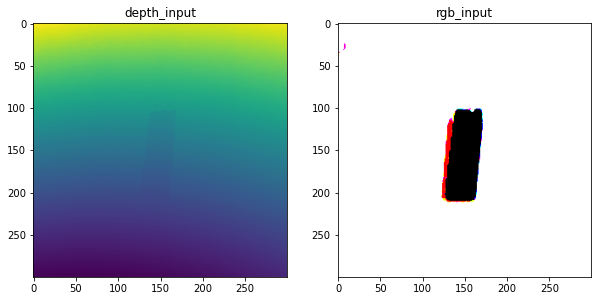

In [60]:
depth_img = xc[0][0].data.numpy()
rgb_img = xc[0][1:4].data.numpy()
plt.figure(figsize = (10,10))
rgb_img = np.moveaxis(rgb_img,0,2)*255
plt.subplot(121)
plt.title('depth_input')
plt.imshow(depth_img)
plt.subplot(122)
plt.title('rgb_input')
plt.imshow(rgb_img)
plt.show()

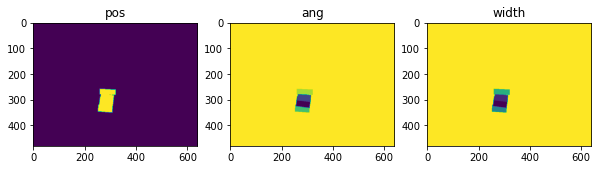

In [61]:
pos = yc[0][0][0].data.numpy()
ang = yc[1][0][0].data.numpy()
wid = yc[2][0][0].data.numpy()
plt.figure(figsize = (10,10))
plt.subplot(131)
plt.title('pos')
plt.imshow(pos)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang)
plt.subplot(133)
plt.title('width')
plt.imshow(wid)
plt.show()

可以看到，这就是数据集原始图片所对应的抓取框，跟我们裁剪过的图片已经不对应了，这样训练是不可能有结果的，所以需要将这些映射也裁剪成跟上面一样的尺寸，使其保持坐标的对应。

#### 输出的裁减
- 方法一：首先这块也可以通过直接裁剪的方式实现，比如下面实验一下：

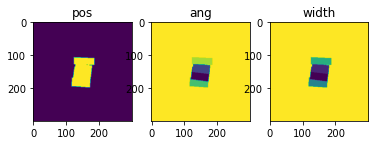

In [62]:
# 获取裁切角点坐标
grasps = Grasps.load_from_cornell_files(cpos_path[0])

output_size = 300
left = int(grasps.center[0]-output_size//2)
top = int(grasps.center[1]-output_size//2)

pos_croped = pos[top:top+output_size, left:left+output_size]
ang_croped = ang[top:top+output_size, left:left+output_size]
wid_croped = wid[top:top+output_size, left:left+output_size]

plt.subplot(131)
plt.title('pos')
plt.imshow(pos_croped)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang_croped)
plt.subplot(133)
plt.title('width')
plt.imshow(wid_croped)
plt.show()

如上图所示， 成功将抓取框移动到了裁切后图片的中央，只需将crop函数集成到Cornell class，然后在get_grasp中应用裁切函数，裁切图片后返回

- 方法二：平移的方法


读取多个grasp_rectangles的平均中心坐标，将所有抓取框从中心坐标移动到位于坐标原点的crop_rectangle上

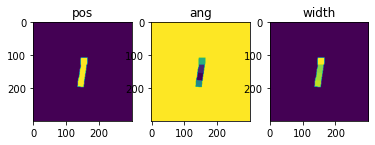

In [71]:
#注意一定要将这一块放在最后，因为这个是为了测试ggcnn原始函数而设置的，导入这个类之后会影响前面的定义
#一开始我没怎么搞懂ggcnn里面是怎么工作的，所以就索性用它默认设计的类来测试一下

from grasp_ggcnn import GraspRectangles
from grasp_ggcnn import GraspRectangle
from grasp_ggcnn import Grasp

output_size = 300
grs = GraspRectangles.load_from_cornell_file(cpos_path[0])

#它就是通过这一行来修正抓取框坐标的，相当于把抓取框的坐标整体向左上方平移了一下，使其位于我生成图像的中心
grs.offset((-(grs.center[0]-output_size//2),-((grs.center[1]-output_size//2))))
pos,ang,width = grs.draw((300,300))

plt.subplot(131)
plt.title('pos')
plt.imshow(pos)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang)
plt.subplot(133)
plt.title('width')
plt.imshow(width)


如上图所示，生成的抓取框矩形沿着手指张开的方向缩小了3倍，出于安全期间，gripper的中心位于此处，才能保证夹取成功

另外这块还有一点需要注意，就是ggcnn里面将抓取框矩形矩形沿着手指的方向变窄了三倍，这也是我之前想到的一个问题，是很合理的，总能不能说你标的边缘处也能应用那些抓取参数吧，具体操作是在构建Grasp对象的时候把length参数除了3,实现这个功能定义了一个新的类Grasp_cpaw(对应原始ggcnn中的Grasp类)，这个类中抓取矩形是由中心点坐标(center),角度(angle),张开宽度(width),手指宽度(length)定义的,这样也才能操作length/3这一操作,然后再通过这个类的as_gr方法转换回以脚点坐标表征的Grasp类,我方法一生成的没有除（上上图），方法二的除了，所以要窄了许多（上图）：

In [72]:
from grasp_pro import Grasp
from grasp_pro import Grasps
from grasp_pro import Grasp_cpaw

grs = Grasps.load_from_cornell_files(cpos_path[0])
test = Grasp_cpaw(grs.grs[0].center, grs.grs[0].angle, grs.grs[0].length, grs.grs[0].width).as_gr

#把这些参数打印出来看框还是不是原先的框
print(grs.grs[0].points)
print(test.points)

[[253 320]
 [309 324]
 [307 350]
 [251 346]]
[[252.92894788 319.99472969]
 [308.92894788 323.99472969]
 [307.07105212 350.00527031]
 [251.07105212 346.00527031]]


In [73]:
print(grs.grs[0].center)
print(test.center)

print(grs.grs[0].angle)
print(test.angle)

print(grs.grs[0].width)
print(test.width)

print(grs.grs[0].length)
print(test.length)

[280 335]
[280 335]
-0.07130746478529026
-0.07130746478529026
56.142675390472796
56.14267539047277
26.076809620810597
26.0768096208106


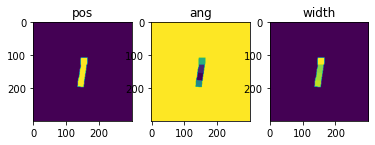

In [75]:
output_size = 300
grs = Grasps.load_from_cornell_files(cpos_path[0])

#它就是通过这一行来修正抓取框坐标的，相当于把抓取框的坐标整体向左上方平移了一下，使其位于我生成图像的中心
grs.offset((-int(grs.center[0]-output_size//2),-int(grs.center[1]-output_size//2)))
pos,ang,width = grs.generate_img((300,300))

plt.subplot(131)
plt.title('pos')
plt.imshow(pos)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang)
plt.subplot(133)
plt.title('width')
plt.imshow(width)
plt.show()